## **Paper Information**

**Master: Meta Style Transformer for Controllable Zero-Shot and Few-Shot Artistic Style Transfer, CVPR 2023**, Hao Tang, Songhua Liu, Tianwei Lin, Shaoli Huang, Fu Li, Dongliang He, Xinchao Wang

*   Paper Link: https://openaccess.thecvf.com/content/CVPR2023/papers/Tang_Master_Meta_Style_Transformer_for_Controllable_Zero-Shot_and_Few-Shot_Artistic_CVPR_2023_paper.pdf


**Project Group Members:**

*   Melih Gökay Yiğit, gokay.yigit@metu.edu.tr
*   Veli Umut Özyurt, umut.ozyurt@metu.edu.tr

## **Paper Summary**

### **Introduction**

Artistic style transfer, the process of applying the stylistic elements of one image to the content of another, has gained significant attention in recent years. Traditional methods often struggle with limitations such as over-parameterization and content distortion when employing Transformer-based models. While Transformers excel at capturing global context and complex dependencies, their multi-layer structures result in a heavy computational burden and increased difficulty in training. Furthermore, the standard use of residual connections in Transformers can lead to unwanted content distortion, undermining the integrity of the original content structure.

This paper introduces Master: Meta Style Transformer, a novel approach designed to address these challenges. By sharing parameters across different Transformer layers and implementing a learnable scaling mechanism, the Master model reduces the overall number of parameters, improves training convergence, and enhances the quality of stylization. Additionally, a meta-learning framework allows for efficient adaptation to new styles, making the model versatile for both zero-shot and few-shot style transfer scenarios. The innovative design not only alleviates the computational burden but also achieves superior results in maintaining content fidelity and stylization quality, thereby pushing the boundaries of what’s achievable in artistic style transfer.

### **Model Architecture and Training**

The proposed Meta Style Transformer (Master) model comprises three main components: an encoder, a feature modification module, and a decoder (Figure 1). The encoder leverages the first two stages of the Swin Transformer to extract features from both content and style images. The feature modification module, named Style Transformer, alternates between Transformer encoder and decoder layers with shared parameters across all layers, enabling efficient training and reducing the overall parameter count. The decoder reconstructs the stylized image from the modified features.

<div style="text-align: center;">
    <figure>
        <img src="./src/model.png" alt="Model Architecture Overview" style="width:1200px; height:auto;">
        <figcaption> <b> Figure 1.</b> Model Architecture Overview.</figcaption>
    </figure>
</div>

During the training phase, the model employs a two-stage process: meta training and fast adaptation. The meta training stage, inspired by the Reptile algorithm [(Nichol et al., 2018)](https://arxiv.org/abs/1803.02999), seeks an optimal initialization that allows the model to quickly adapt to new styles with minimal updates. This stage involves sampling styles and performing inner optimizations to guide the updates of the model parameters. The fast adaptation stage fine-tunes the model for specific styles, focusing on updating only the Transformer encoder layers, which significantly speeds up the adaptation process.


#### Encoder Architecture

The encoder in the Master model uses the first two stages of the Swin Transformer [(Liu et al., 2021)](https://arxiv.org/abs/2103.14030) (Figure 2.), which is designed to efficiently capture image features through hierarchical and shifted window attention mechanisms. This architecture divides the input content and style images into 4x4 patches, allowing the encoder to extract multi-scale features that are essential for detailed and coherent style transfer. The Swin Transformer’s hierarchical structure and local attention ensure that both global and local information are effectively captured, providing a robust foundation for subsequent feature modification and decoding. This efficient and powerful encoding process is crucial for achieving high-quality style transfer with reduced computational complexity.

<div style="text-align: center;">
    <figure>
        <img src="./src/swin.png" alt="Swin Transformer Architecture Overview" style="width:1200px; height:auto;">
        <figcaption> <b> Figure 2.</b> Swin Transformer Architecture Overview.</figcaption>
    </figure>
</div>

#### StyleTransformer Architecture

The Style Transformer is the core component responsible for content-style interaction and modification within the Master model. This architecture alternates between Transformer encoder and decoder layers, with parameters shared across all layers to reduce computational overhead and facilitate efficient training. A feature of this model is the use of shifted window attention [(Liu et al., 2021)](https://arxiv.org/abs/2103.14030) in the all multi-head attention (MHA) blocks, which enhances the efficiency and scalability of the model by focusing attention within local windows that shift across layers.

A crucial aspect of the Style Transformer is the replacement of traditional residual connections with learnable scaling and shifting parameters. The use of learnable scaling and shifting parameters addresses the problem of content distortion commonly seen in traditional residual connections. By dynamically adjusting the content features based on these parameters, the model preserves the original content structure more effectively. This method allows the model to achieve a balanced integration of style and content, resulting in stylized images that retain the essential characteristics of the original content while adopting the desired artistic style.

##### Transformer Encoder Layer

The Transformer encoder layer processes features related to the style and generates three key outputs: style parameters $K_s$, scaling parameters $V_σ$, and shifting parameters $V_μ$. The style features are first processed using self-attention, which captures dependencies within the style image itself. The prediction of each part shares a same self-attention map to save memory but uses independent non-linear transformation. The process in the Transformer encoder layer can be formulated as:


$$
MHA(Q, K, V) = [head_1, ..., head_h]W^O
$$

$$
head_i = Att(QW^{Q_i}, KW^{K_i}, VW^{V_i})
$$

$$
Att(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$

$$
K'_s = K_s + MHA(K_s, K_s, K_s)
$$

$$
K_s = K'_s + MLP(K'_s)
$$

$$
V'_σ = V_σ + MHA(K_s, K_s, V_σ)
$$

$$
V_σ = V'_σ + MLP(V'_σ)
$$

$$
V'_μ = V_μ + MHA(K_s, K_s, V_μ)
$$

$$
V_μ = V'_μ + MLP(V'_μ)
$$


Following self-attention, the style features are passed through a multi-layer perceptron (MLP) block for non-linear transformation. This process generates the keys needed for cross-attention in the decoder layer, as well as the learnable scaling and shifting parameters. These parameters are crucial for preserving the integrity of the content structure while effectively blending in the style features. Also, authors don't incorporated normalization to encode style features since second-order statistics can largely represent style information.

##### Transformer Decoder Layer

In the Transformer decoder layer, the encoded content features undergo a series of transformations to integrate style information. Initially, the content features are processed using self-attention to model internal dependencies. The cross-attention step follows, where scaling and shifting parameters for each content feature point is aggregated from $V_σ$ and $V_μ$ respectively according to the cross-attention map of content features (queries) and style features generated by the encoder (keys). The process in one Transformer decoder block can be written as:


$$
F'_{cs} = F_{cs} + MHA(F_{cs}, F_{cs}, F_{cs})
$$

$$
\sigma = MHA(IN(F'_{cs}), IN(K_{s}), V_{\sigma})
$$

$$
\mu = MHA(IN(F'_{cs}), IN(K_{s}), V_{\mu})
$$

$$
F''_{cs} = \sigma \odot F'_{cs} + \mu
$$

$$
F_{cs} = F''_{cs} + MLP(F''_{cs})
$$


Instead of using traditional residual connections, which can distort the original content structure, the Style Transformer employs dynamic and learnable scaling and shifting operations. These operations adjust the content features based on the scaling and shifting parameters derived from the style encoder. This approach helps to maintain the original spatial relationships and similarities within the content image while incorporating vivid style patterns, ensuring high-quality and coherent style transfer.


#### Decoder Architecture

The final step in the Master model is the decoder, which synthesizes the stylized image from the modified content features. The decoder follows a standard architecture [(Huang & Belongie, 2017)](https://arxiv.org/abs/1703.06868) with multiple upsampling convolutional blocks that progressively reconstruct the high-resolution image from the transformed features.

### Training Pipeline

The training process of the MASTER model involves two key stages: meta training (Algorithm 1.) and fast adaptation. This dual-stage approach enables the model to learn a robust initial state that can be quickly adapted to new styles with minimal updates.


<div style="text-align: center;">
    <figure>
        <img src="./src/meta.png" alt="Meta Training Algorithm" style="width:600px; height:600px;">
        <figcaption> <b> Algorithm 1.</b> Meta Training Algorithm.</figcaption>
    </figure>
</div>


#### Meta Training

Inspired by the Reptile algorithm [(Nichol et al., 2018)](https://arxiv.org/abs/1803.02999), the meta training stage aims to find an optimal initialization for the neural network, allowing it to adapt rapidly to new style transfer tasks. During this stage, the model undergoes a series of inner and outer loop updates:

1. **Inner Loop**: For each iteration, a style image is sampled, and the current model parameters are used to perform a series of updates on a batch of content images. The number of Transformer layers used in each iteration is randomly sampled, which helps the model learn to generalize across different configurations. The loss computed in this step guides the updates to obtain "fast weights."

2. **Outer Loop**: The "fast weights" obtained from the inner loop are used to adjust the model's "slow weights" or meta parameters. This step ensures that the model gradually learns an initialization that performs well across various styles and configurations.

By training in this manner, the model learns a versatile initialization that can be fine-tuned quickly and efficiently for specific styles, significantly reducing the overall training time required for each new style.

#### Fast Adaptation

Once the meta training stage is complete, the model is fine-tuned for specific styles through fast adaptation. This stage is crucial for few-shot style transfer scenarios, where the model must adapt to a new style with only a few examples. The fast adaptation process is similar to the inner loop of the meta training stage but focuses on fine-tuning the parameters of the Transformer encoder layer:

1. **Initialization**: The model starts with the parameters learned during the meta training stage.
2. **Few-Shot Updates**: For the new style, the model performs a limited number of updates using a small set of style images. Only the parameters of the Transformer encoder layer are updated during this stage, which significantly reduces the memory and computational requirements.

This targeted fine-tuning allows the model to quickly adapt to new styles, achieving high-quality stylization with minimal training data and computational effort. The fast adaptation stage ensures that the Master model can handle both zero-shot and few-shot style transfer scenarios effectively, providing a flexible and powerful solution for artistic style transfer tasks.

### Loss Functions

The training of the Master model utilizes a combination of content and style loss functions to ensure high-quality stylization while preserving the structure of the content image. 

#### Content Loss

The content loss aims to maintain the semantic structure and details of the original content image in the stylized output. This is achieved using a normalized perceptual loss, which compares the features of the content and stylized images extracted from a pre-trained VGG19 network. The content loss is defined as:

$$
L_{\text{cont}} = \sum_{x=2}^5 \| \text{IN}(F^x_c) - \text{IN}(F^x_{cs}) \|^2 
$$

where $F^x$ represents the features from layer $x$ of the VGG19 network [(Simonyan & Zisserman, 2017)](https://arxiv.org/abs/1409.1556), and $\text{IN}$ denotes instance normalization. This loss ensures that the stylized image retains the structural integrity of the original content image.

#### Style Loss

The style loss measures the degree to which the stylized image matches the style of the reference style image. This is achieved using the mean-variance loss, which compares the channel-wise mean and standard deviation of the features from the style and stylized images. The style loss is defined as:


$$
L_{\text{sty}} = \sum_{x=2}^5 \left( \| \mu(F^x_s) - \mu(F^x_{cs}) \|^2 + \| \sigma(F^x_s) - \sigma(F^x_{cs}) \|^2 \right)
$$


where $\mu$ and $\sigma$ denote the channel-wise mean and standard deviation, respectively. This loss ensures that the stylized image captures the texture and color patterns of the style image.

#### Combined Loss

The overall objective during training is to balance the content and style losses. The combined loss function is given by:

$$
L = L_{\text{cont}} + \lambda L_{\text{sty}}
$$

where $\lambda$ is a hyper-parameter that controls the balance between content preservation and style rendering. By adjusting $\lambda$, the model can be fine-tuned to emphasize either content fidelity or stylization quality.



# Importing Libraries

In [1]:
import os
import glob
import cv2
import numpy as np
import argparse
import sys
import matplotlib.pyplot as plt

project_root_path = os.getcwd()

sys.path.append(project_root_path)

import torch
import torch.nn as nn
from torchvision import transforms


from train_only_inner_loop import Train
from test_model import Test


from codes.full_model import MasterStyleTransferModel
from codes.loss import custom_loss

/home/umut/miniconda3/envs/ceng796/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hyperparameters

In [2]:
# set the parser
parser = argparse.ArgumentParser(description= 'Master: Meta Style Transformer for Controllable Zero-Shot and Few-Shot Artistic Style Transfer Implementation')
args = parser.parse_args(args=[])

In [3]:
args.project_root =  os.getcwd()

args.model_save_path = "exps/models"

args.coco_dataset_path = "datasets/coco_train_dataset/train2017"

args.wikiart_dataset_path = "datasets/wikiart/**"

args.loss_model_path = "weights/vgg_19_last_layer_is_relu_5_1_output.pt"

args.use_vgg19_with_batchnorm = False

args.batch_size_style = 1

args.batch_size_content = 4

args.num_workers = 4

args.shuffle = True

args.use_infinite_sampler = True

args.pin_memory = True

args.freeze_encoder = True

args.inner_lr = 0.0001

args.outer_lr = 0.0001

args.num_inner_updates = 1

args.max_layers = 4

args.lambda_style = 10.0

args.loss_distance_content = 'euclidian'

args.loss_distance_style = 'euclidian'

args.use_random_crop = True

args.use_imagenet_normalization_for_swin = True

args.use_imagenet_normalization_for_loss = True

args.save_every = 100

args.save_every_for_model = 1000

args.max_iterations = 15000

args.swin_model_relative_path = "weights/swin_B_first_2_stages.pt"

args.swin_variant = "swin_B"

args.style_encoder_dim = 256

args.style_decoder_dim = 256

args.style_encoder_num_heads = 8

args.style_decoder_num_heads = 8

args.style_encoder_window_size = [7, 7]

args.style_decoder_window_size = [7, 7]

args.style_encoder_shift_size = [4, 4]

args.style_decoder_shift_size = [4, 4]

args.style_encoder_mlp_ratio = 4.0

args.style_decoder_mlp_ratio = 4.0

args.style_encoder_dropout = 0.0

args.style_decoder_dropout = 0.0

args.style_encoder_attention_dropout = 0.0

args.style_decoder_attention_dropout = 0.0

args.style_encoder_qkv_bias = True

args.style_decoder_qkv_bias = True

args.style_encoder_proj_bias = True

args.style_decoder_proj_bias = True

args.style_encoder_stochastic_depth_prob = 0.1

args.style_decoder_stochastic_depth_prob = 0.1

args.style_encoder_norm_layer = None

args.style_decoder_norm_layer = nn.LayerNorm

args.style_encoder_MLP_activation_layer = nn.GELU

args.style_decoder_MLP_activation_layer = nn.GELU

args.style_encoder_if_use_processed_Key_in_Scale_and_Shift_calculation = True

args.style_decoder_use_instance_norm_with_affine = False

args.style_decoder_use_regular_MHA_instead_of_Swin_at_the_end = False

args.style_decoder_use_Key_instance_norm_after_linear_transformation = True

args.style_decoder_exclude_MLP_after_Fcs_self_MHA = False

args.decoder_initializer = "kaiming_normal_"

args.style_transformer_load_pretrained_weights = False

args.style_transformer_pretrained_weights_path = "weights/model_basic_layer_1_module_list_shifted_window_block_state_dict.pth"

args.use_wandb = False

args.online = True

args.exp_name = 'master'

args.set_seed = False

args.seed = 42

args.verbose = True


### Change from original hyperparameters:

In [7]:
# We changed some of the default values, which is decided by our experiments. We have failed with over 100 different trials.
# To demonstrate the our best results (where content is somehow preserved), you can use the following parameters.


# If you want to use the default parameters, do not run this cell.

args.set_seed = True # Set the seed for reproducibility

args.seed = 42 # Set the seed to 42

args.use_wandb = True # Use wandb for logging

args.batch_size_content = 2 # THIS IS DUE TO GPU MEMORY LIMITATIONS. IF IT CAN BE INCREASED, IT IS BETTER TO USE 4.

args.max_iterations = 25000 # Increase the number of iterations

args.save_every = 50 # Save the output images every 50 iterations with wandb


# loss choices aligned better with the loss values for the screenshots obtained from the paper (screenshots are used as content, style and output to pick them)
args.loss_distance_content="euclidian_squared" # Use euclidian squared distance for content loss

args.loss_distance_style="euclidian" # Use euclidian distance for style loss (default)

args.use_imagenet_normalization_for_loss=False # Do not use imagenet normalization for loss


args.pretrained_style_transformer_path = ""
args.pretrained_decoder_path = ""

args.fast_adaptation_stage_on = False # Do not use fast adaptation stage

args.decoder_initializer = "default" # Use pytorch's default initializer for decoder

args.inner_lr = 0.00001 # Decrease the inner learning rate (default is 0.0001 for inner loop)

args.lambda_style = 1.5 # Decrease the weight of style loss (in our experiments, whenever we use high style lambda coefficient, content was quickly lost)

args.exp_name = "experiment_54" # Name of our experiment

# If you want to use the default parameters, do not run this cell.

# Setting Device

In [8]:
# Set the device
args.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(args.device)

cuda:0


# Train

In [9]:
# For demonstration purposes, we will run low amount of iterations
args.max_iterations = 20

# Create the trainer
trainer = Train(config=args)

# Start the training
trainer.train()

Using seed 42


AttributeError: 'Namespace' object has no attribute 'pretrained_style_transformer_path'

# Loading Pre-trained Model

In [6]:
# pretrained model paths
decoder_path = "test/pretrained_weights/experiment_54_decoder.pt"
style_transformer_path = "test/pretrained_weights/experiment_54_style_transformer.pt"

# load the model
master_style_transfer_model = MasterStyleTransferModel(
    project_absolute_path = os.getcwd(),
    swin_model_relative_path = "weights/swin_B_first_2_stages.pt",
    swin_variant = "swin_B",
    style_encoder_dim = 256,
    style_decoder_dim = 256,
    style_encoder_num_heads = 8,
    style_decoder_num_heads = 8,
    style_encoder_window_size = [7, 7],
    style_decoder_window_size = [7, 7],
    style_encoder_shift_size = [4, 4],
    style_decoder_shift_size = [4, 4],
    style_encoder_mlp_ratio = 4.0,
    style_decoder_mlp_ratio = 4.0,
    style_encoder_dropout = 0.0,
    style_decoder_dropout = 0.0,
    style_encoder_attention_dropout = 0.0,
    style_decoder_attention_dropout = 0.0,
    style_encoder_qkv_bias = True,
    style_decoder_qkv_bias = True,
    style_encoder_proj_bias = True,
    style_decoder_proj_bias = True,
    style_encoder_stochastic_depth_prob = 0.1,
    style_decoder_stochastic_depth_prob = 0.1,
    style_encoder_norm_layer = None,
    style_decoder_norm_layer = torch.nn.LayerNorm,
    style_encoder_MLP_activation_layer = torch.nn.GELU,
    style_decoder_MLP_activation_layer = torch.nn.GELU,
    style_encoder_if_use_processed_Key_in_Scale_and_Shift_calculation = True,
    style_decoder_use_instance_norm_with_affine = False,
    style_decoder_use_regular_MHA_instead_of_Swin_at_the_end = False,
    style_decoder_use_Key_instance_norm_after_linear_transformation = True,
    style_decoder_exclude_MLP_after_Fcs_self_MHA = False,
    style_transformer_load_pretrained_weights = False,
    direct_pretrained_style_transformer_path = style_transformer_path,
    direct_pretrained_decoder_path = decoder_path,
)

# set the model to evaluation mode
master_style_transfer_model.eval()


Loading the pretrained weights to the style transformer
Pretrained weights are loaded to the style transformer


Loading the pretrained weights to the decoder
Pretrained weights are loaded to the decoder



MasterStyleTransferModel(
  (swin_encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=512, out_features=128, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTra

## Run the model on test set

In [11]:
# define the flags
CALCULATE_STYLE_CONTENT_LOSS = True
CALCULATE_SIMILARITY_LOSS = False

SAVE_OUTPUTS = True

# test folder paths
content_images_path = "test/content_input"
style_images_path = "test/style_input"


output_path = "test/output_images"

if not os.path.exists(output_path):
    os.makedirs(output_path)


test_transform = transforms.Compose([
    transforms.ToPILImage(), # -> PIL image
    transforms.Resize((256, 256)), # -> resize to 512x512
    transforms.ToTensor()
])

imagenet_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

test_device = "cuda" if torch.cuda.is_available() else "cpu"

if CALCULATE_STYLE_CONTENT_LOSS:
    # create the loss instance
    loss_instance = custom_loss(
        project_absolute_path=os.getcwd(),
        feature_extractor_model_relative_path="weights/vgg_19_last_layer_is_relu_5_1_output.pt",
        use_vgg19_with_batchnorm=False,
        default_lambda_value=10.0,
        distance_content="euclidian_squared",
        distance_style="euclidian"
    )

    # set the loss instance to evaluation mode
    loss_instance.eval()

# load the loss instance to the device
loss_instance = loss_instance.to(test_device)


# load the model to the device
master_style_transfer_model = master_style_transfer_model.to(test_device)


# get the content image list
content_image_list = glob.glob(os.path.join(content_images_path, "*"))

# get the style image list
style_image_list = glob.glob(os.path.join(style_images_path, "*"))

trial = test_transform(cv2.cvtColor(cv2.imread(content_image_list[0]), cv2.COLOR_BGR2RGB))

# open all images and preprocess them

processed_content_images = []
processed_style_images = []

for image_path in content_image_list:
    processed_content_images.append(test_transform(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)))

for image_path in style_image_list:
    processed_style_images.append(test_transform(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)))


if CALCULATE_STYLE_CONTENT_LOSS:
    # create a loss list
    total_loss_list = []
    content_loss_list = []
    style_loss_list = []

    if CALCULATE_SIMILARITY_LOSS:
        similarity_loss_list = []


# DETERMINE THE TRANSFORMER LAYER COUNT TO BE USED
transformer_layer_counts_to_try = [1, 3, 5]

for transformer_layer_count in transformer_layer_counts_to_try:
    print(f"FOR TRANSFORMER LAYER COUNT: {transformer_layer_count}")

    # iterate over all combinations of content and style images
    for content_image, content_image_path in zip(processed_content_images, content_image_list):

        # load the content image
        content_image = content_image.unsqueeze(0).to(test_device)

        # get the content image name wihtout the extension
        content_image_name = os.path.basename(content_image_path).split(".")[0]


        for style_image, style_image_path in zip(processed_style_images, style_image_list):

            # load the style image
            style_image = style_image.unsqueeze(0).to(test_device)

            # get the style image name wihtout the extension
            style_image_name = os.path.basename(style_image_path).split(".")[0]

            # get the output image name
            output_image_name = f"{content_image_name}_stylized_with_{style_image_name}_layers_{transformer_layer_count}.jpg"

            # get the output image path
            output_image_path = os.path.join(output_path, output_image_name)

            # get the stylized image
            with torch.no_grad():
                stylized_image = master_style_transfer_model(imagenet_normalization(content_image),
                                                             imagenet_normalization(style_image),
                                                             transformer_layer_count=transformer_layer_count)
            
                if CALCULATE_STYLE_CONTENT_LOSS:
                    # calculate the loss
                    loss = loss_instance(content_image,
                                        stylized_image,
                                        style_image,
                                        output_content_and_style_loss=True,
                                        output_similarity_loss=CALCULATE_SIMILARITY_LOSS)

                    if CALCULATE_SIMILARITY_LOSS:
                        total_loss, content_loss, style_loss, similarity_loss = loss

                        total_loss_list.append(total_loss.item())
                        content_loss_list.append(content_loss.item())
                        style_loss_list.append(style_loss.item())
                        similarity_loss_list.append(similarity_loss.item())
                    else:
                        total_loss, content_loss, style_loss = loss

                        total_loss_list.append(total_loss.item())
                        content_loss_list.append(content_loss.item())
                        style_loss_list.append(style_loss.item())

            

            if SAVE_OUTPUTS:
                # save the stylized image (conver from BGR to RGB and save it as uint8)
                cv2.imwrite(output_image_path, cv2.cvtColor(np.clip(stylized_image.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255, 0, 255).astype(np.uint8), cv2.COLOR_BGR2RGB))


    if CALCULATE_STYLE_CONTENT_LOSS:
        total_loss_mean = np.mean(total_loss_list)
        total_loss_std = np.std(total_loss_list)
        total_loss_confidence_interval = 1.96 * total_loss_std / np.sqrt(len(total_loss_list))

        content_loss_mean = np.mean(content_loss_list)
        content_loss_std = np.std(content_loss_list)
        content_loss_confidence_interval = 1.96 * content_loss_std / np.sqrt(len(content_loss_list))

        style_loss_mean = np.mean(style_loss_list)
        style_loss_std = np.std(style_loss_list)
        style_loss_confidence_interval = 1.96 * style_loss_std / np.sqrt(len(style_loss_list))

        print(f"Total Loss Mean: {total_loss_mean:.2f}, Total Loss Std: {total_loss_std:.2f}, Confidence Interval: [{total_loss_mean - total_loss_confidence_interval:.2f}, {total_loss_mean + total_loss_confidence_interval:.2f}]")
        print(f"Content Loss Mean: {content_loss_mean:.2f}, Content Loss Std: {content_loss_std:.2f}, Confidence Interval: [{content_loss_mean - content_loss_confidence_interval:.2f}, {content_loss_mean + content_loss_confidence_interval:.2f}]")
        print(f"Style Loss Mean: {style_loss_mean:.2f}, Style Loss Std: {style_loss_std:.2f}, Confidence Interval: [{style_loss_mean - style_loss_confidence_interval:.2f}, {style_loss_mean + style_loss_confidence_interval:.2f}]")

        if CALCULATE_SIMILARITY_LOSS:
            similarity_loss_mean = np.mean(similarity_loss_list)
            similarity_loss_std = np.std(similarity_loss_list)
            similarity_loss_confidence_interval = 1.96 * similarity_loss_std / np.sqrt(len(similarity_loss_list))

            print(f"Similarity Loss Mean: {similarity_loss_mean:.2f}, Similarity Loss Std: {similarity_loss_std:.2f}, Confidence Interval: [{similarity_loss_mean - similarity_loss_confidence_interval:.2f}, {similarity_loss_mean + similarity_loss_confidence_interval:.2f}]")

        print("\n")

FOR TRANSFORMER LAYER COUNT: 1
Total Loss Mean: 55.06, Total Loss Std: 16.68, Confidence Interval: [52.86, 57.27]
Content Loss Mean: 7.60, Content Loss Std: 0.14, Confidence Interval: [7.58, 7.62]
Style Loss Mean: 4.75, Style Loss Std: 1.66, Confidence Interval: [4.53, 4.97]


FOR TRANSFORMER LAYER COUNT: 3
Total Loss Mean: 52.40, Total Loss Std: 16.17, Confidence Interval: [50.89, 53.91]
Content Loss Mean: 7.60, Content Loss Std: 0.14, Confidence Interval: [7.59, 7.61]
Style Loss Mean: 4.48, Style Loss Std: 1.61, Confidence Interval: [4.33, 4.63]


FOR TRANSFORMER LAYER COUNT: 5
Total Loss Mean: 50.09, Total Loss Std: 15.46, Confidence Interval: [48.91, 51.27]
Content Loss Mean: 7.60, Content Loss Std: 0.14, Confidence Interval: [7.59, 7.61]
Style Loss Mean: 4.25, Style Loss Std: 1.54, Confidence Interval: [4.13, 4.37]




## Calculate and display random results

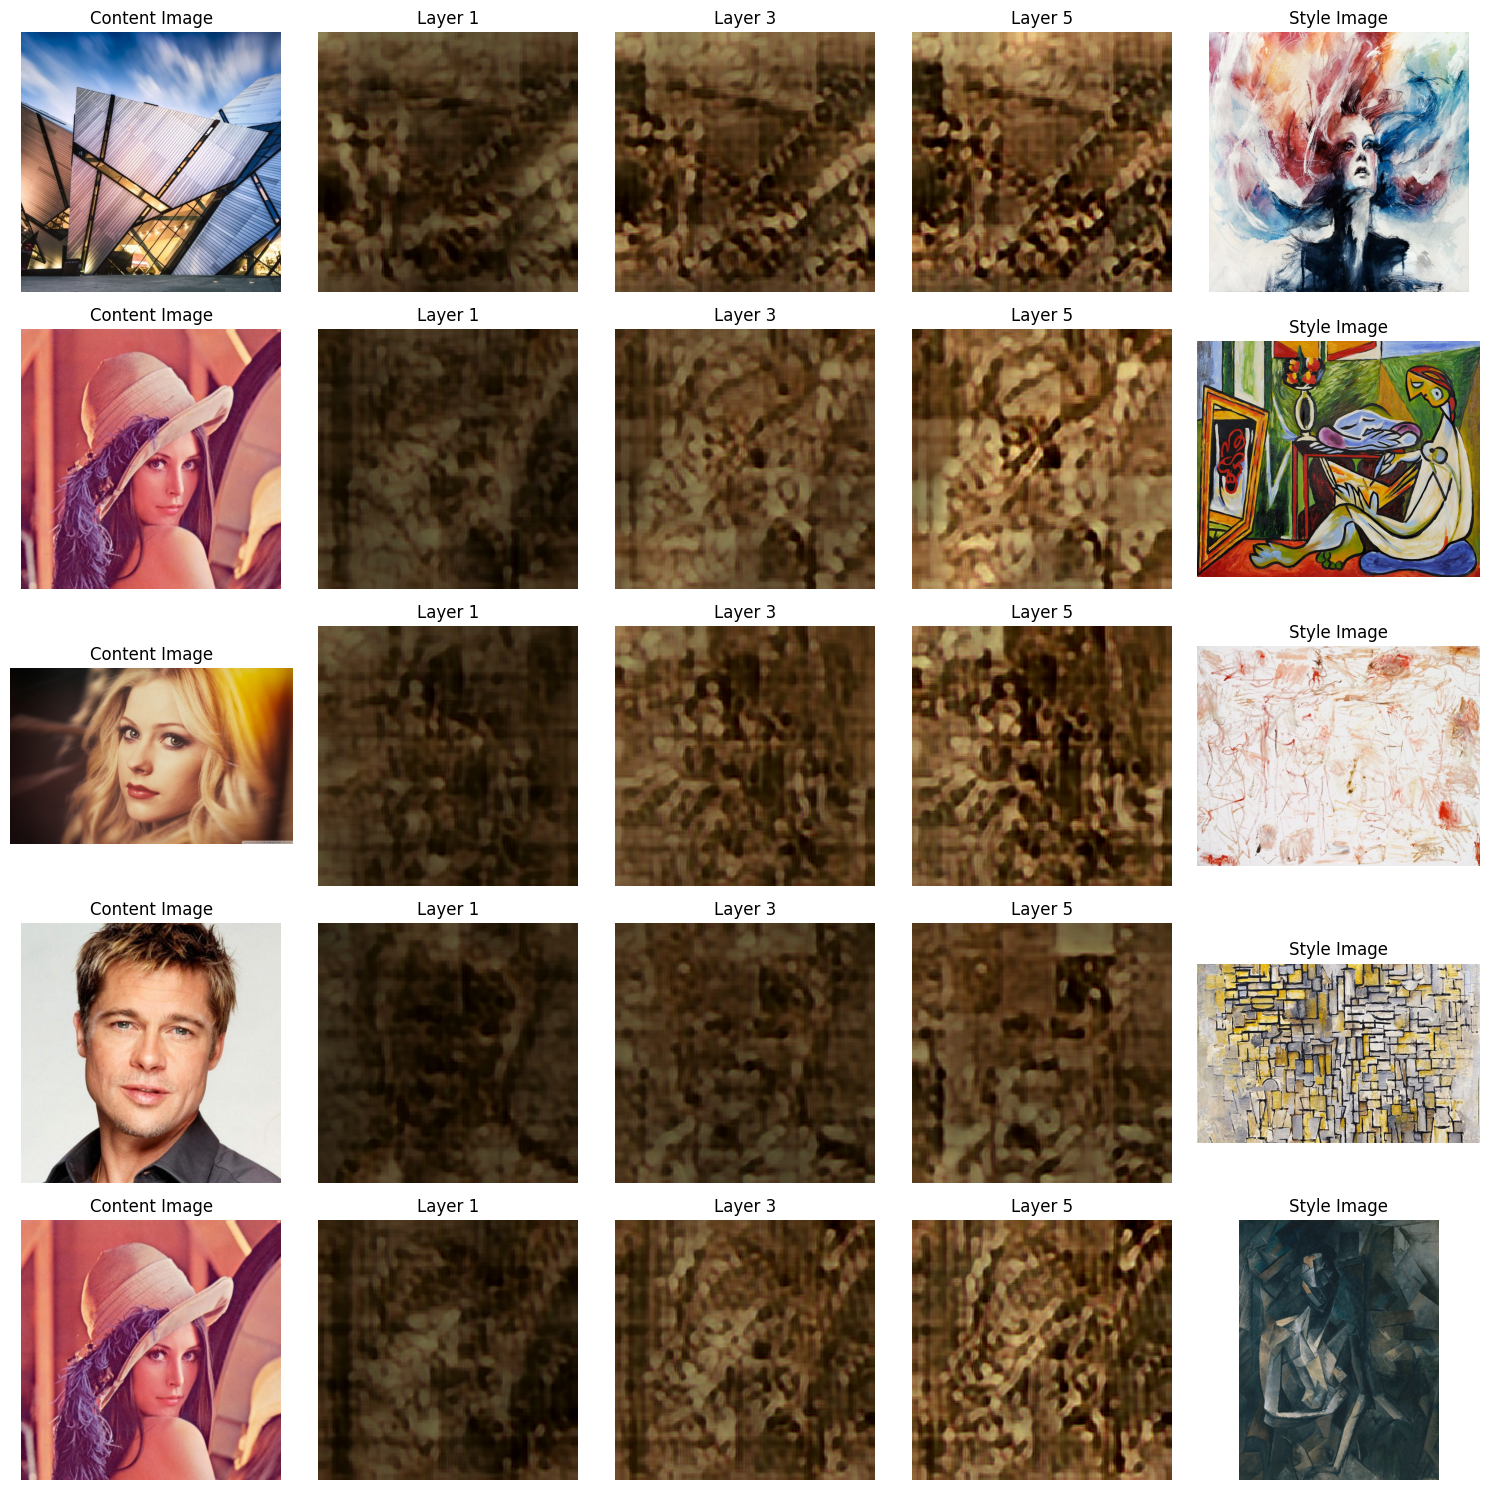

In [18]:
# pick a random image num
random_image_num = 5

# select random content and style images
random_content_paths = np.random.choice(content_image_list, random_image_num)
random_style_paths = np.random.choice(style_image_list, random_image_num)

# create a random_image_num x 3 grid (content, output_layer1, output_layer3, output_layer5, style)
fig, axes = plt.subplots(random_image_num, 5, figsize=(15, 15))

for i in range(random_image_num):
    # load the content image
    content_image = test_transform(cv2.cvtColor(cv2.imread(random_content_paths[i]), cv2.COLOR_BGR2RGB)).unsqueeze(0).to(test_device)

    # load the style image
    style_image = test_transform(cv2.cvtColor(cv2.imread(random_style_paths[i]), cv2.COLOR_BGR2RGB)).unsqueeze(0).to(test_device)

    # get the stylized image (with normalizations)
    with torch.no_grad():
        stylized_image_layer1 = master_style_transfer_model(imagenet_normalization(content_image),
                                                            imagenet_normalization(style_image),
                                                            transformer_layer_count=1)

        stylized_image_layer3 = master_style_transfer_model(imagenet_normalization(content_image),
                                                            imagenet_normalization(style_image),
                                                            transformer_layer_count=3)

        stylized_image_layer5 = master_style_transfer_model(imagenet_normalization(content_image),
                                                            imagenet_normalization(style_image),
                                                            transformer_layer_count=5)
    
    # display the images
    axes[i, 0].imshow(cv2.cvtColor(cv2.imread(random_content_paths[i]), cv2.COLOR_BGR2RGB))
    axes[i, 0].axis("off")
    axes[i, 0].set_title("Content Image")

    axes[i, 1].imshow(np.clip(stylized_image_layer1.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1))
    axes[i, 1].axis("off")
    axes[i, 1].set_title("Layer 1")

    axes[i, 2].imshow(np.clip(stylized_image_layer3.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1))
    axes[i, 2].axis("off")
    axes[i, 2].set_title("Layer 3")

    axes[i, 3].imshow(np.clip(stylized_image_layer5.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1))
    axes[i, 3].axis("off")
    axes[i, 3].set_title("Layer 5")

    axes[i, 4].imshow(cv2.cvtColor(cv2.imread(random_style_paths[i]), cv2.COLOR_BGR2RGB))
    axes[i, 4].axis("off")
    axes[i, 4].set_title("Style Image")

    

plt.tight_layout()
plt.show()